In [730]:
import pandas as pd
import warnings
from sodapy import Socrata
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt


client = Socrata("data.ny.gov", None)

ds_dictionary = {
    'ridership': 'vxuj-8kew',
    'subway hourly ridership': 'wujg-7c2s',
    'bus hourly ridership': 'kv7t-n8in',
    'major felonies': 'yeek-jhmu',
    'summonses and arrests since 2019': '7tfn-twae'
}

time_column_dictionary = {'date', 'timestamp', 'month'}

In [1277]:
def get_dataset(ds_name: str, begin: str=None, before: str=None) -> pd.DataFrame:
    sample = client.get(ds_dictionary[ds_name], limit=1)
    time_columns = [v for v in sample[0].keys() if v.lower().endswith(tuple(time_column_dictionary))]
    
    if len(time_columns) == 0:
        warnings.warn(f'No time column found: {sample[0].keys}')
        try:
            res_dict = client.get_all(ds_dictionary[ds_name])
            return pd.DataFrame.from_records(res_dict).dropna().reset_index(drop=True)
        except Exception as e:
            raise Exception(f"Couldn't get all rows. Too many? {e}")

    if len(time_columns) > 1:
        raise Exception(f'Too many time columns found: {sample.keys}')

    time_column = time_columns[0]
    where_string = f"{time_column} >= '{begin}'" if begin and not before else ''
    where_string = f"{time_column} < '{before}'" if not begin and before else ''
    where_string = f"{time_column} >= '{begin}' AND {time_column} < '{before}'" if begin and before else ''
    res_dict = client.get_all(ds_dictionary[ds_name], where=where_string, order=f'{time_column} ASC')
    return pd.DataFrame.from_records(res_dict).dropna().reset_index(drop=True)


def aggregate_by_timeframe(df: pd.DataFrame, timeframe: str, typ: str) -> pd.DataFrame:
    if timeframe not in ['hourly', 'daily', 'weekly', 'monthly']:
        raise Exception(f'Invalid timeframe {timeframe}')
    if typ not in ['mean', 'sum']:
        raise Exception(f'Invalid type {typ}')
    
    time_columns = [v for v in df.columns if v.lower().endswith(tuple(time_column_dictionary))]
    if len(time_columns) != 1:
        raise Exception(f'Zero or more than one time column(s) found: {df.columns}')

    time_column = time_columns[0]
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    for column in df.columns:
        if column != time_column:
            try:
                df[column] = df[column].astype(float)
            except ValueError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')
            except TypeError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')

    df = df.set_index(time_column)
    timeframe_dictionary = {'hourly': 'h', 'daily': 'd', 'weekly': 'W', 'monthly': 'ME'}

    if typ == 'mean': return df.resample(timeframe_dictionary[timeframe]).mean(numeric_only=True).reset_index() 
    if typ == 'sum':return df.resample(timeframe_dictionary[timeframe]).sum(numeric_only=True).reset_index() 


In [1285]:
df = get_dataset('ridership')

In [1314]:
df_agg = aggregate_by_timeframe(df, 'monthly', 'sum')

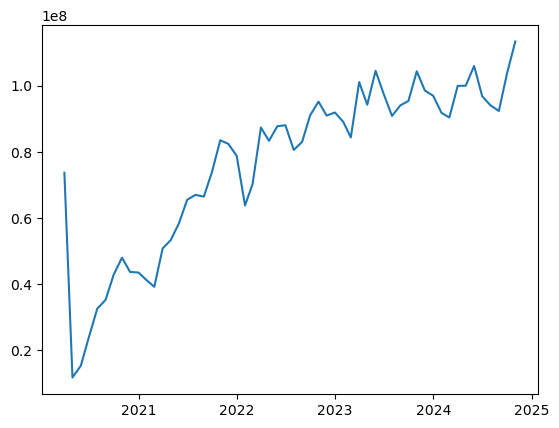

In [1316]:
plt.plot(df_agg.date[:-1], df_agg.subways_total_estimated_ridership[:-1])